In [50]:
# Install Libraries used
install.packages("tseries")
install.packages("forecast")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



DTA LOADING AND FIND BEST PARAMETERS

In [51]:
# DTA LOADING AND FIND BEST PARAMETERS
library(forecast)
# Load your time series data
data_set <- scan("/content/wwwusage.txt", skip = 1)

In [52]:
# Load the dataset of WWW usage (number of users connected to the Internet)
cat("Loaded Dataset \n")
cat(replicate(13, "-----"))
cat('\n')
print(data_set)


Loaded Dataset 
----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- -----
  [1]  88  84  85  85  84  85  83  85  88  89  91  99 104 112 126 138 146 151
 [19] 150 148 147 149 143 132 131 139 147 150 148 145 140 134 131 131 129 126
 [37] 126 132 137 140 142 150 159 167 170 171 172 172 174 175 172 172 174 174
 [55] 169 165 156 142 131 121 112 104 102  99  99  95  88  84  84  87  89  88
 [73]  85  86  89  91  91  94 101 110 121 135 145 149 156 165 171 175 177 182
 [91] 193 204 208 210 215 222 228 226 222 220


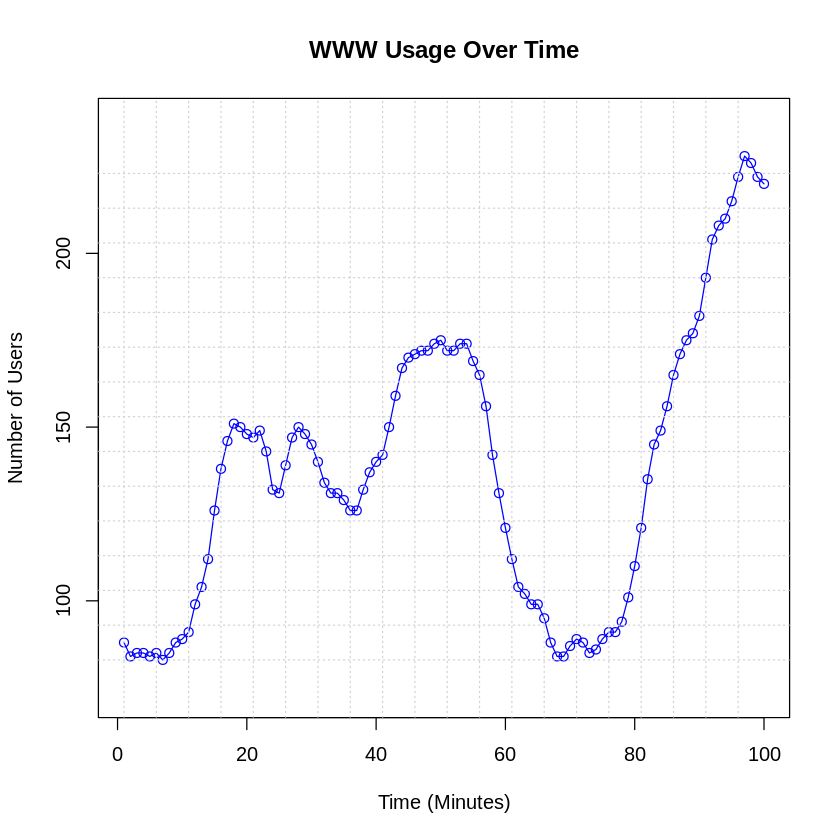

In [53]:

# Basic statistical exploration
minimum_value <- min(data_set)
maximum_value <- max(data_set)
average_value <- mean(data_set)

# Plotting the initial time series
plot(data_set, type = "o", main = "WWW Usage Over Time", xlab = "Time (Minutes)", ylab = "Number of Users", ylim = c(minimum_value - 10, maximum_value + 10), col = "blue")
# Adding a grid
abline(h = seq(from = floor(minimum_value), to = ceiling(maximum_value), by = 10), col = "lightgray", lty = "dotted")
abline(v = seq(from = 1, to = length(data_set), by = 5), col = "lightgray", lty = "dotted")


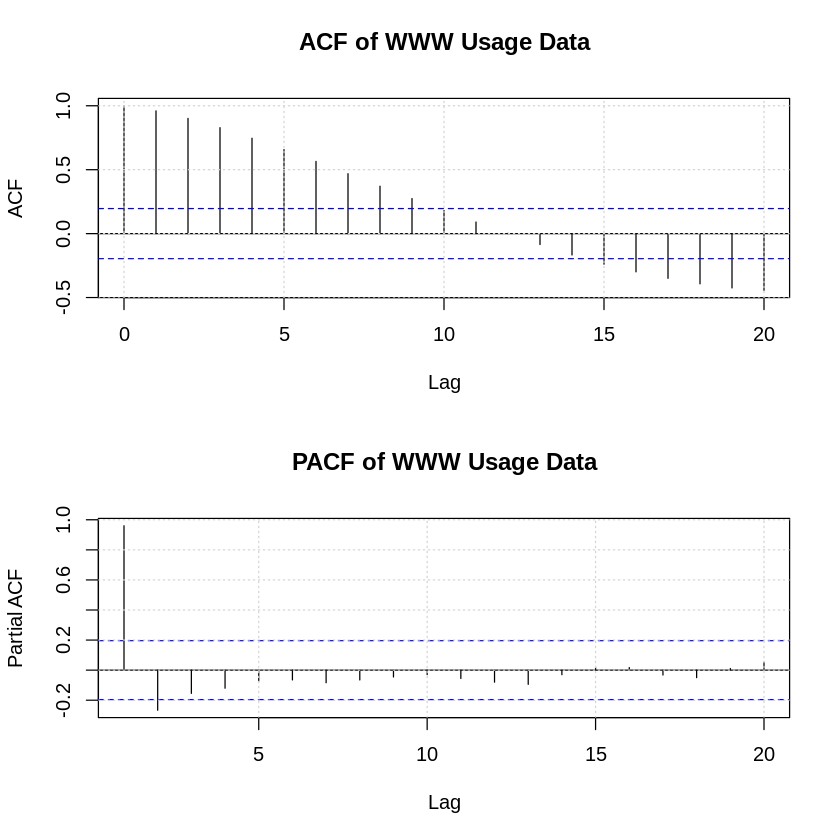

In [54]:

# Autocorrelation and Partial Autocorrelation Plots
par(mfrow=c(2,1)) # Set up a 2x1 grid for plots
acf(data_set, main = "ACF of WWW Usage Data")
grid()
pacf(data_set, main = "PACF of WWW Usage Data")
grid()

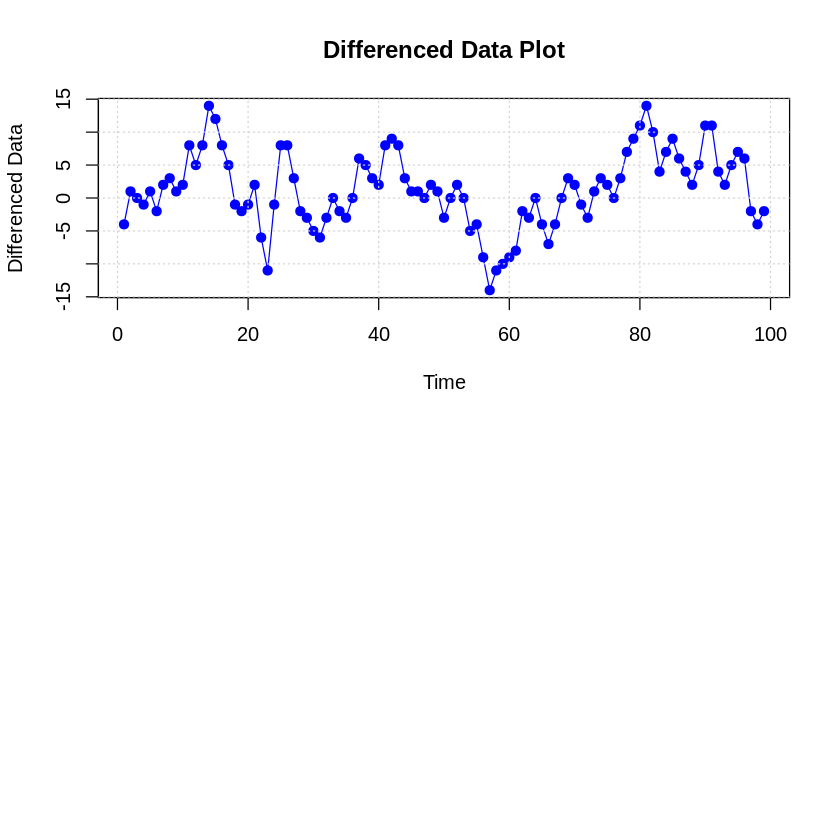

In [55]:

# Differencing the series for stationarity
par(mfrow=c(2,1)) # Set up a 2x1 grid for plots
differenced_data <- diff(data_set)
# Plot differenced data
plot(differenced_data, type = "o", col = "blue",pch =19,
     xlab = "Time", ylab = "Differenced Data",
     main = "Differenced Data Plot")
grid()


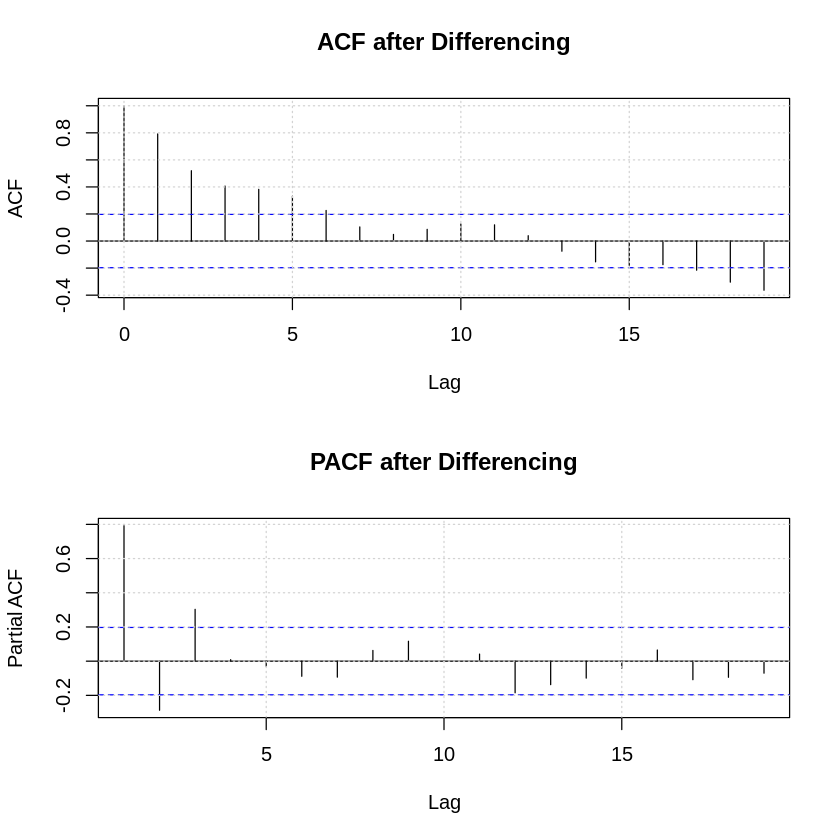

In [56]:

par(mfrow=c(2,1)) # Set up a 2x1 grid for plots
# Autocorrelation and Partial Autocorrelation of Differenced Data
acf(differenced_data, main = "ACF after Differencing")
grid()
pacf(differenced_data, main = "PACF after Differencing")
grid()


In [57]:
# Simple mode d=1
differenced_data_1 = diff(data_set, differences = 1)
ar.yw(differenced_data_1, max=9)


Call:
ar.yw.default(x = differenced_data_1, max = 9)

Coefficients:
      1        2        3  
 1.1060  -0.5957   0.3029  

Order selected 3  sigma^2 estimated as  10.32

In [58]:
# Simple model d=2
differenced_data_2 = diff(data_set, differences = 2)
ar.yw(differenced_data_2, max=9)


Call:
ar.yw.default(x = differenced_data_2, max = 9)

Coefficients:
      1        2  
 0.2489  -0.4341  

Order selected 2  sigma^2 estimated as  10.56

<h1 style='color:blue'>After above simple model, it's a good practice to considel best ARIMA model to AIC,BIC,HQC for both d =1, and d = 2 </h1>
<h3>Code below wxecute above tasks</h3>

In [77]:

n <- length(data_set)

# Initialize lists to store models and their evaluations
models_list <- list()
aic_values <- setNames(numeric(), character())
bic_values <- setNames(numeric(), character())
hqc_values <- setNames(numeric(), character())

# Define ranges for p, d, q
p_range <- 0:9
d_range <- 0:3
q_range <- 0:9

# Fit models
for (p in p_range) {
    for (d in d_range) {
        for (q in q_range) {
            model_id <- paste("ARIMA(", p, ",", d, ",", q, ")", sep = "")
            model <- suppressWarnings(tryCatch({
                arima(data_set, order = c(p, d, q))
            }, error=function(e) NULL))
            if (!is.null(model)) {
                models_list[[model_id]] <- model
                aic_values[model_id] <- AIC(model)
                bic_values[model_id] <- BIC(model)
                hqc_values[model_id] <- -2 * logLik(model) + 2 * length(coef(model)) * log(log(n))
            }
        }
    }
}

# Function to print best models for differencing 1 and 2
print_best_models <- function(d) {
    d_models <- names(aic_values)[grepl(sprintf(",%d,", d), names(aic_values))]
    if (length(d_models) == 0) {
        cat(sprintf("No models fitted for differencing %d\n\n", d))
        return()
    }

    aic_best <- d_models[which.min(aic_values[d_models])]
    bic_best <- d_models[which.min(bic_values[d_models])]
    hqc_best <- d_models[which.min(hqc_values[d_models])]

    # Extract the model orders from the model ids
    aic_order <- strsplit(gsub("ARIMA\\(|\\)", "", aic_best), ",")[[1]]
    bic_order <- strsplit(gsub("ARIMA\\(|\\)", "", bic_best), ",")[[1]]
    hqc_order <- strsplit(gsub("ARIMA\\(|\\)", "", hqc_best), ",")[[1]]

    cat("For differencing", d, ":\n")
    cat("AIC Best Model: ARIMA(", paste(aic_order, collapse = ","), ")\n")
    cat("BIC Best Model: ARIMA(", paste(bic_order, collapse = ","), ")\n")
    cat("HQC Best Model: ARIMA(", paste(hqc_order, collapse = ","), ")\n\n")
}

# Print best models for d=1 and d=2
cat("Size:", n, "\n")
print_best_models(1)
print_best_models(2)


Size: 100 
For differencing 1 :
AIC Best Model: ARIMA( 5,1,4 )
BIC Best Model: ARIMA( 1,1,1 )
HQC Best Model: ARIMA( 3,1,0 )

For differencing 2 :
AIC Best Model: ARIMA( 5,2,5 )
BIC Best Model: ARIMA( 2,2,0 )
HQC Best Model: ARIMA( 2,2,0 )



In [60]:
# BEST MODELS FOUND ABOVE
# Sample size
n <- length(data_set)
# Define the models to fit found from above section of codes
models_to_fit <- list(
  c(1, 1, 1),
  c(3, 1, 0),
  c(5, 1, 4),
  c(5, 2, 5),
  c(2, 2, 0)
)

# Fit the models and store their AIC, BIC, and HQC values
for (model_params in models_to_fit) {
  p <- model_params[1]
  d <- model_params[2]
  q <- model_params[3]

  model <- suppressWarnings(tryCatch({
    arima(data_set, order = c(p, d, q))
  }, error=function(e) NULL))

  if (!is.null(model)) {
    model_id <- paste(p, d, q, sep = "-")
    models_list[[model_id]] <- model
    aic_values <- c(aic_values, AIC(model))
    bic_values <- c(bic_values, BIC(model))
    # Calculate HQC
    k <- length(coef(model))
    hqc <- -2 * logLik(model) + 2 * k * log(log(n))
    hqc_values <- c(hqc_values, hqc)
  }
}

# Print the AIC, BIC, and HQC values for the specified models
for (i in 1:length(models_to_fit)) {
  model_id <- paste(models_to_fit[[i]], collapse = "-")
  cat("Model(", model_id, ")\n")
  cat("AIC:", aic_values[which(names(models_list) == model_id)], "\n")
  cat("BIC:", bic_values[which(names(models_list) == model_id)], "\n")
  cat("HQC:", hqc_values[which(names(models_list) == model_id)], "\n\n")
}


Model( 1-1-1 )
AIC: 514.2995 
BIC: 522.0848 
HQC: 514.4082 

Model( 3-1-0 )
AIC: 511.994 
BIC: 522.3745 
HQC: 513.1571 

Model( 5-1-4 )
AIC: 511.1394 
BIC: 537.0906 
HQC: 518.6286 

Model( 5-2-5 )
AIC: 509.8191 
BIC: 538.2538 
HQC: 518.3627 

Model( 2-2-0 )
AIC: 511.4645 
BIC: 519.2194 
HQC: 511.5733 



In [61]:
# Best Model Generated by complex Algorithm
arima_310_order <-  c(3, 1, 0)
arima_111_order <-  c(1, 1, 1)
arima_514_order <-  c(5, 1, 4)

best_aic_order <- c(5, 2, 5)  # For AIC
best_bic_order <- c(2, 2, 0)  # For BIC
best_hqc_order <- c(2, 2, 0)  # For HQC, which is same as BIC in your results


In [62]:

# Model fitting with ARIMA based on prior analysis
# our best AIC model is ARIMA(5,2,5) and the best BIC/HQC model is ARIMA(2,2,0) ARIMA(1,1,1), ARIMA(3,1,0)
# Fitting these models
arima_111_model <- arima(data_set, order = arima_111_order)
arima_310_model <- arima(data_set, order = arima_310_order)
arima_514_model <- arima(data_set, order = arima_514_order)
best_aic_model <- arima(data_set, order = best_aic_order)
best_bic_hqc_model <- arima(data_set, order = best_bic_order) # This is also the best model by HQC as per your results


ARIMA(1,1,1) Model Output

Call:
arima(x = data_set, order = arima_111_order)

Coefficients:
         ar1     ma1
      0.6504  0.5256
s.e.  0.0842  0.0896

sigma^2 estimated as 9.793:  log likelihood = -254.15,  aic = 514.3

Training set error measures:
                    ME     RMSE      MAE       MPE     MAPE      MASE
Training set 0.3035616 3.113754 2.405275 0.2805566 1.917463 0.5315228
                    ACF1
Training set -0.01715517



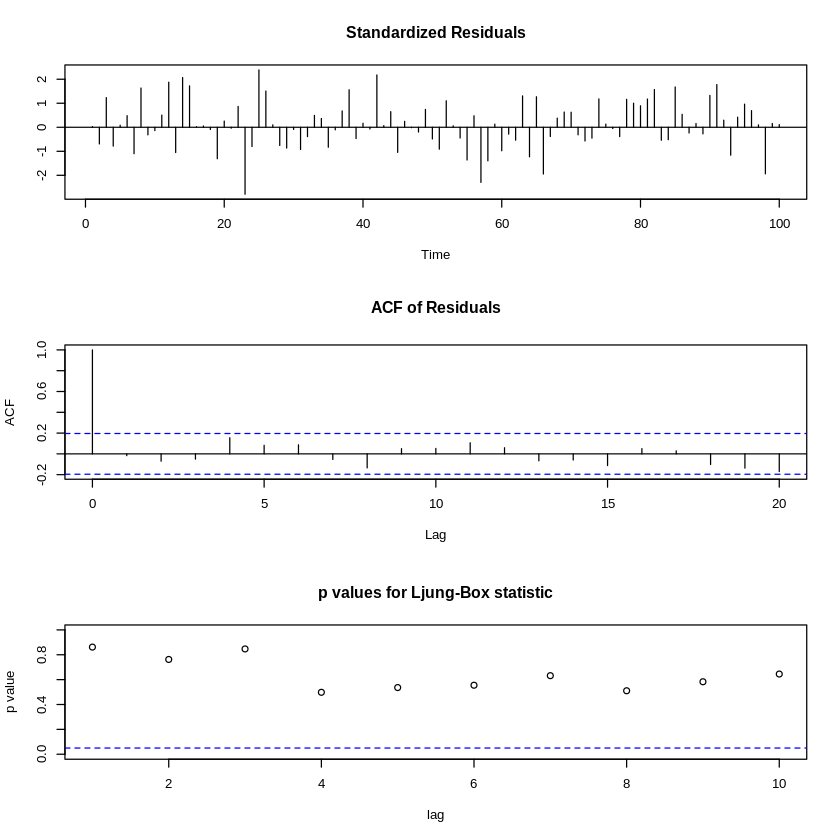

In [63]:
# Model diagnostics
# Display results for ARIMA(1,1,1)
cat("ARIMA(1,1,1) Model Output\n")
print(summary(arima_111_model))
cat("\n")
tsdiag(arima_111_model)

ARIMA(3,1,0) Model Output

Call:
arima(x = data_set, order = arima_310_order)

Coefficients:
         ar1      ar2     ar3
      1.1513  -0.6612  0.3407
s.e.  0.0950   0.1353  0.0941

sigma^2 estimated as 9.363:  log likelihood = -252,  aic = 511.99

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE
Training set 0.230588 3.044632 2.367157 0.2748377 1.890528 0.5230995
                     ACF1
Training set -0.003095065



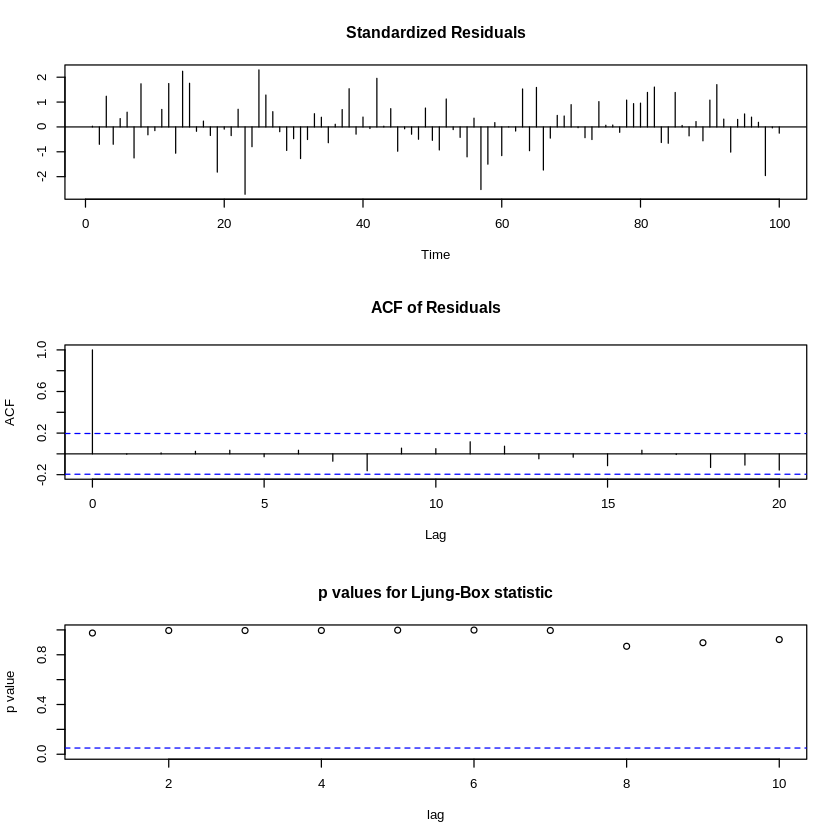

In [64]:
# Display results for ARIMA(3,1,0)
cat("ARIMA(3,1,0) Model Output\n")
print(summary(arima_310_model))
cat("\n")
tsdiag(arima_310_model)

ARIMA(5,1,4) Model Output

Call:
arima(x = data_set, order = arima_111_order)

Coefficients:
         ar1     ma1
      0.6504  0.5256
s.e.  0.0842  0.0896

sigma^2 estimated as 9.793:  log likelihood = -254.15,  aic = 514.3

Training set error measures:
                    ME     RMSE      MAE       MPE     MAPE      MASE
Training set 0.3035616 3.113754 2.405275 0.2805566 1.917463 0.5315228
                    ACF1
Training set -0.01715517



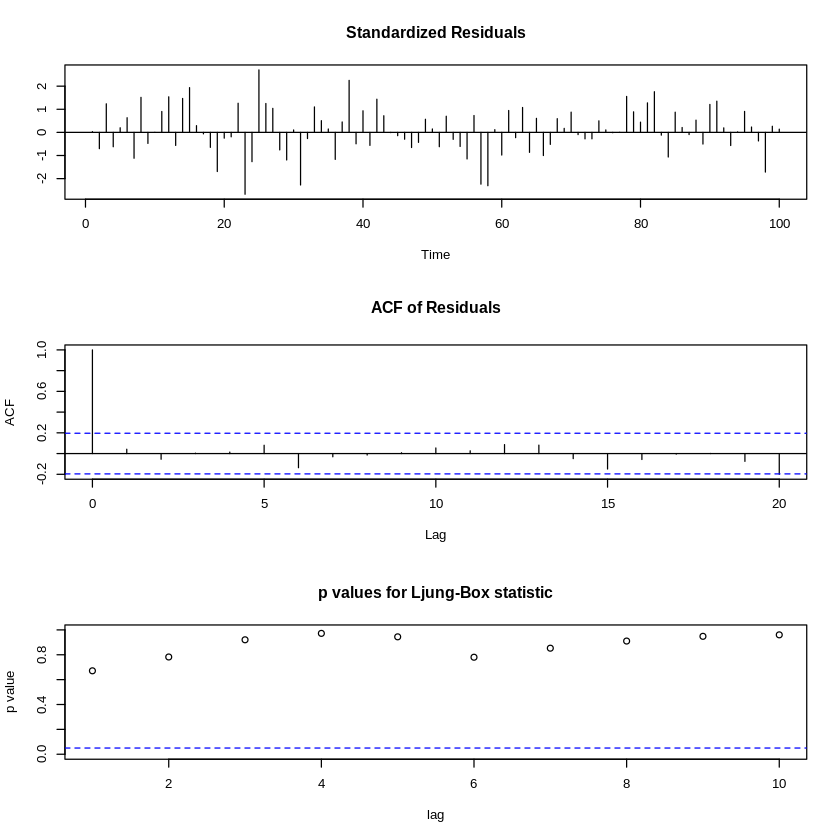

In [65]:
# Model diagnostics
# Display results for ARIMA(1,1,1)
cat("ARIMA(5,1,4) Model Output\n")
print(summary(arima_111_model))
cat("\n")
tsdiag(arima_514_model)

ARIMA(5,2,5) Output

Call:
arima(x = data_set, order = best_aic_order)

Coefficients:
         ar1      ar2     ar3      ar4     ar5      ma1     ma2      ma3
      0.4157  -0.4783  0.0535  -0.2449  0.6034  -0.2850  0.0654  -0.0651
s.e.  0.0870   0.0978  0.1187   0.1016  0.0878   0.0691  0.0754   0.0740
         ma4      ma5
      0.2859  -0.9993
s.e.  0.0714   0.0924

sigma^2 estimated as 7.521:  log likelihood = -243.91,  aic = 509.82

Training set error measures:
                    ME     RMSE      MAE       MPE     MAPE     MASE       ACF1
Training set 0.1330769 2.714929 2.097323 0.2171532 1.640865 0.463471 0.05077024



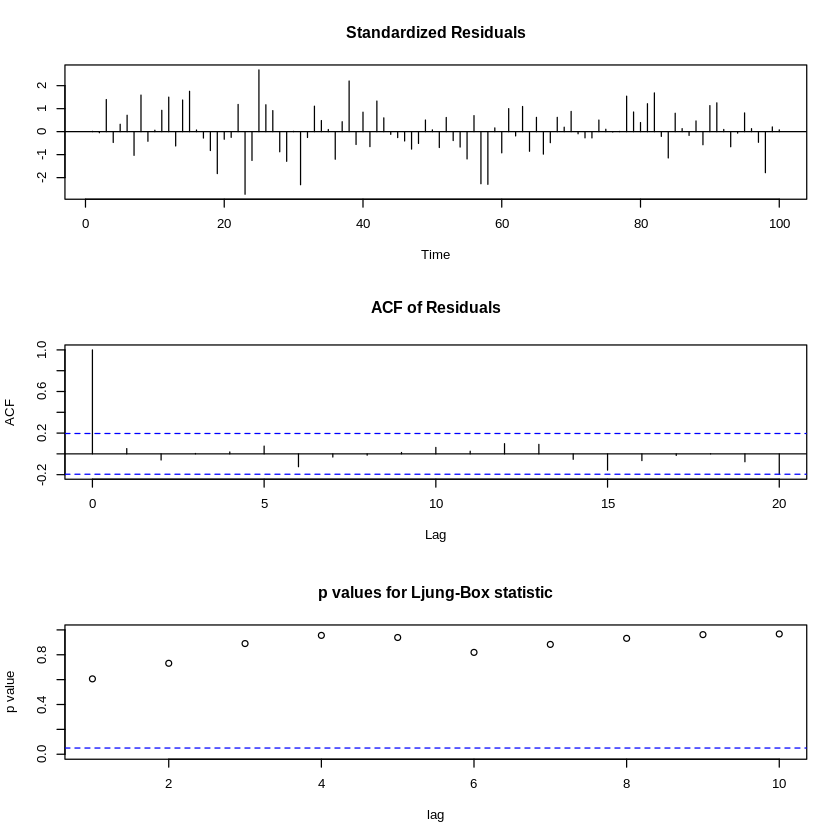

In [66]:
# Display results for Best AIC Model: ARIMA(5,2,5)
cat("ARIMA(5,2,5) Output\n")
print(summary(best_aic_model))
cat("\n")
# Model diagnostics
tsdiag(best_aic_model)



Model: ARIMA(2,2,0) Output

Call:
arima(x = data_set, order = best_bic_order)

Coefficients:
         ar1      ar2
      0.2579  -0.4407
s.e.  0.0915   0.0906

sigma^2 estimated as 10.13:  log likelihood = -252.73,  aic = 511.46

Training set error measures:
                     ME     RMSE      MAE      MPE     MAPE      MASE
Training set 0.02797758 3.150308 2.511921 0.206235 1.994727 0.5550897
                   ACF1
Training set -0.0235521



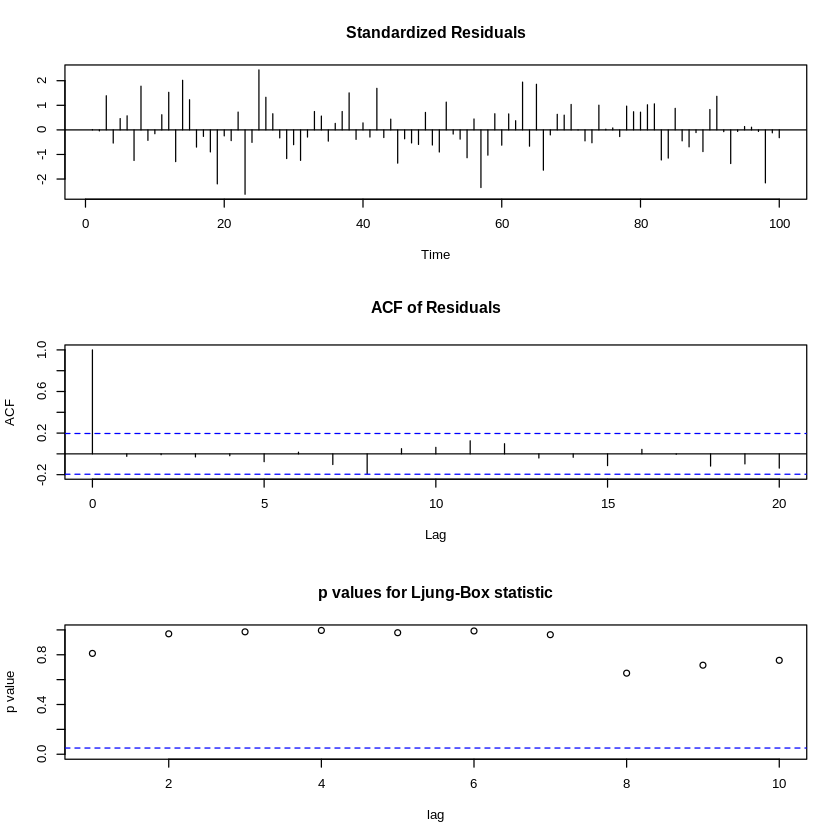

In [67]:
# Display results for Best BIC/HQC Model: ARIMA(2,2,0)
cat("Model: ARIMA(2,2,0) Output\n")
print(summary(best_bic_hqc_model))
cat("\n")
tsdiag(best_bic_hqc_model)

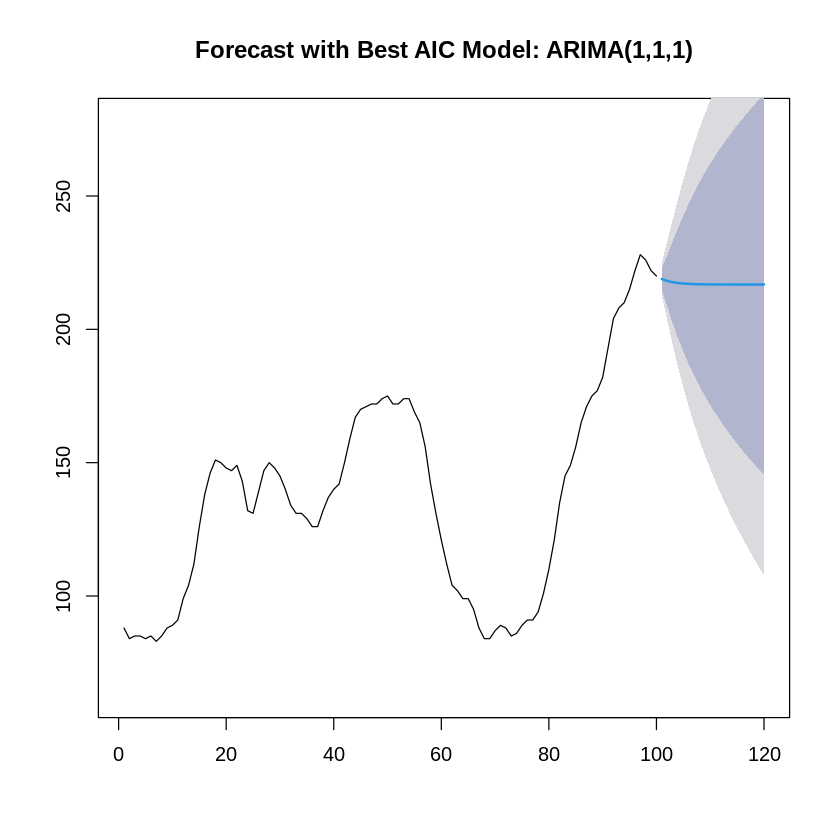

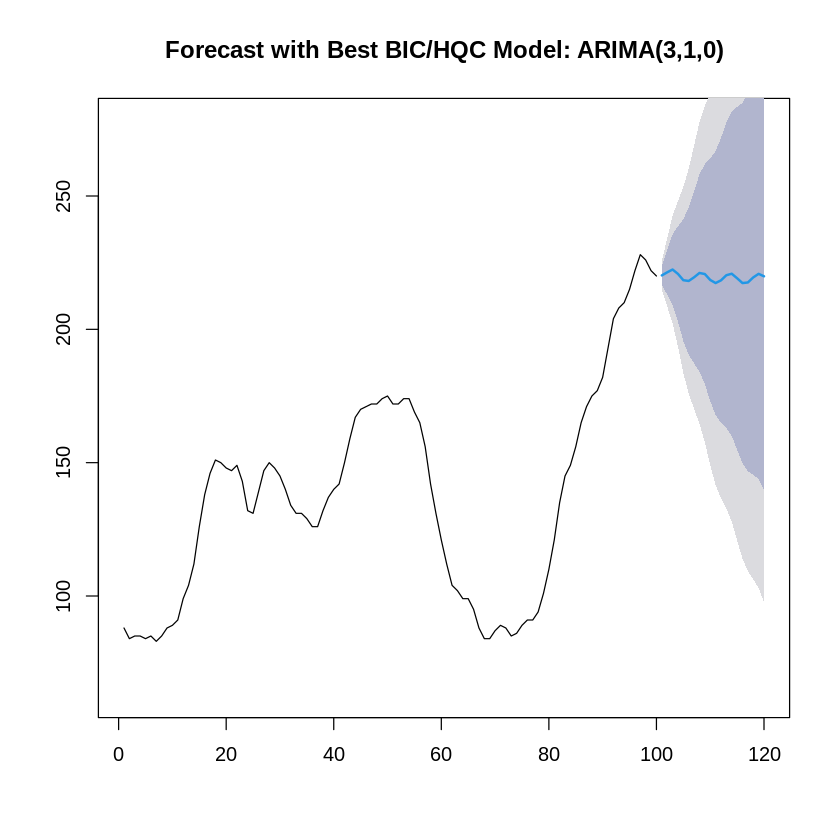

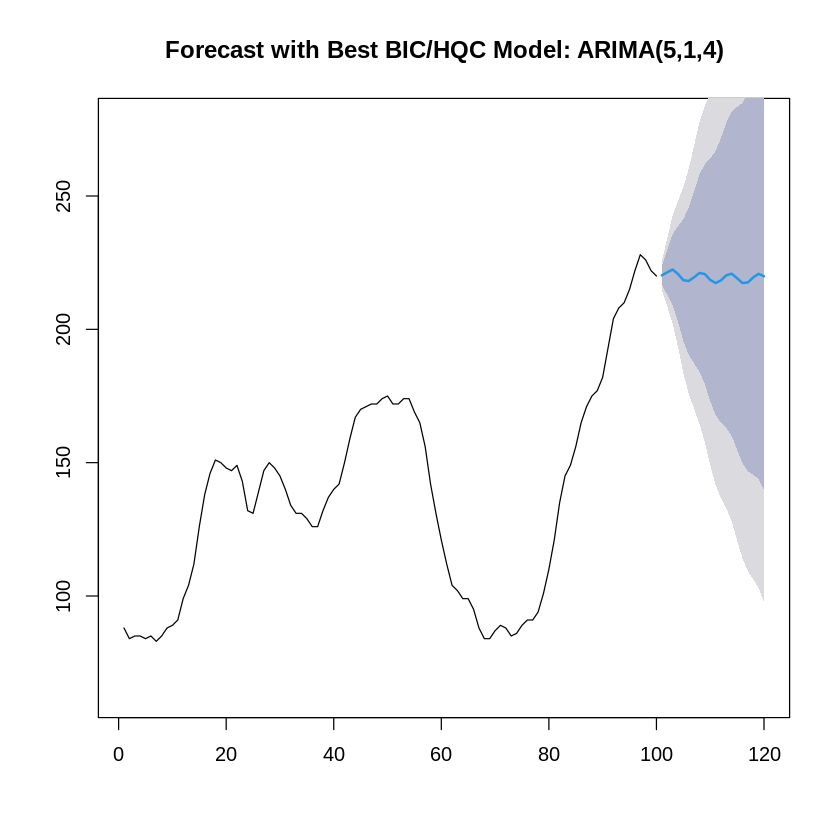

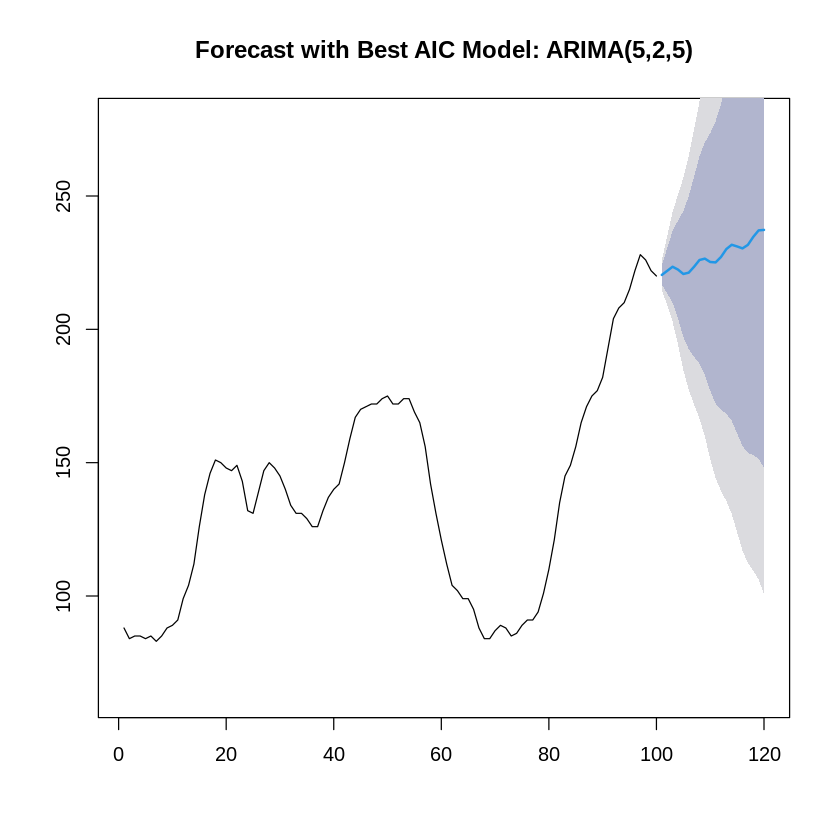

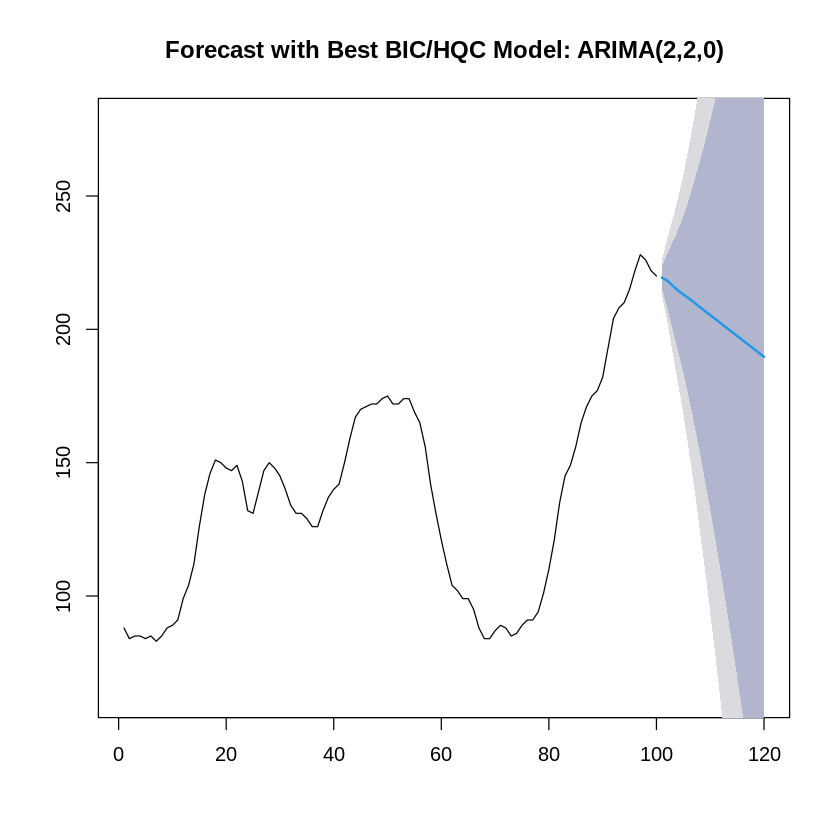

In [68]:

# Forecasting and plotting future values
forecast_aic <- forecast(best_aic_model, h = 20)
forecast_bic_hqc <- forecast(best_bic_hqc_model, h = 20)
forecast_arima_111 <- forecast(arima_111_model, h = 20)
forecast_arima_310 <- forecast(arima_310_model, h = 20)
forecast_arima_310 <- forecast(arima_514_model, h = 20)

plot(forecast_arima_111, main = "Forecast with Best AIC Model: ARIMA(1,1,1)", ylim = c(min(data_set) - 20, max(data_set) + 50))
plot(forecast_arima_310, main = "Forecast with Best BIC/HQC Model: ARIMA(3,1,0)", ylim = c(min(data_set) - 20, max(data_set) + 50))
plot(forecast_arima_310, main = "Forecast with Best BIC/HQC Model: ARIMA(5,1,4)", ylim = c(min(data_set) - 20, max(data_set) + 50))
plot(forecast_aic, main = "Forecast with Best AIC Model: ARIMA(5,2,5)", ylim = c(min(data_set) - 20, max(data_set) + 50))
plot(forecast_bic_hqc, main = "Forecast with Best BIC/HQC Model: ARIMA(2,2,0)", ylim = c(min(data_set) - 20, max(data_set) + 50))



In [69]:
# Model accuracy assessment on a test set
test_set <- window(data_set, start = length(data_set) - 9)

# Forecast using ARIMA(5,2,5)
forecast_aic <- forecast(models_list[["5-2-5"]], h = 10)
# Add a title
cat("\nAccuracy Assessment for Model ARIMA(5,2,5):\n")
# Assess accuracy
round(accuracy(forecast_aic, test_set),4)

# Forecast using ARIMA(2,2,0)
forecast_bic_hqc <- forecast(models_list[["2-2-0"]], h = 10)
# Add a title
cat("\nAccuracy Assessment for Model ARIMA(2,2,0):\n")
# Assess accuracy
round(accuracy(forecast_bic_hqc, test_set),4)

# Forecast using ARIMA(1,1,1)
forecast_arima_111 <- forecast(models_list[["1-1-1"]], h = 10)
# Add a title
cat("\nAccuracy Assessment for Model ARIMA(1,1,1):\n")
# Assess accuracy
round(accuracy(forecast_arima_111, test_set),4)

# Forecast using ARIMA(3,1,0)
forecast_arima_310 <- forecast(models_list[["3-1-0"]], h = 10)
# Add a title
cat("\nAccuracy Assessment for Model ARIMA(3,1,0):\n")
# Assess accuracy
round(accuracy(forecast_arima_310, test_set),4)

# Forecast using ARIMA(3,1,0)
forecast_arima_514 <- forecast(models_list[["5-1-4"]], h = 10)
# Add a title
cat("\nAccuracy Assessment for Model ARIMA(5,1,4):\n")
# Assess accuracy
round(accuracy(forecast_arima_514, test_set),4)



Accuracy Assessment for Model ARIMA(5,2,5):


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.1331,2.7149,2.0973,0.2172,1.6409,0.4635,0.0508,NA
Test set,-8.3453,12.5214,9.4015,-4.1107,4.5757,2.0776,0.6442,1.7504



Accuracy Assessment for Model ARIMA(2,2,0):


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.0280,3.1503,2.5119,0.2062,1.9947,0.5551,-0.0236,NA
Test set,2.3926,14.7508,13.1187,0.7787,6.1556,2.8990,0.6809,2.1865



Accuracy Assessment for Model ARIMA(1,1,1):


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.3036,3.1138,2.4053,0.2806,1.9175,0.5315,-0.0172,NA
Test set,-2.5856,11.3514,9.2651,-1.4666,4.4373,2.0474,0.6411,1.4776



Accuracy Assessment for Model ARIMA(3,1,0):


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.2306,3.0446,2.3672,0.2748,1.8905,0.5231,-0.0031,NA
Test set,-2.1689,12.0719,10.0869,-1.2911,4.8168,2.2290,0.6598,1.6162



Accuracy Assessment for Model ARIMA(5,1,4):


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.2250,2.7198,2.1054,0.2510,1.6547,0.4653,0.0418,NA
Test set,-5.3271,12.2213,9.3202,-2.7428,4.5148,2.0596,0.6695,1.6745



	Ljung-Box test

data:  Residuals from ARIMA(1,1,1)
Q* = 7.8338, df = 8, p-value = 0.4499

Model df: 2.   Total lags used: 10



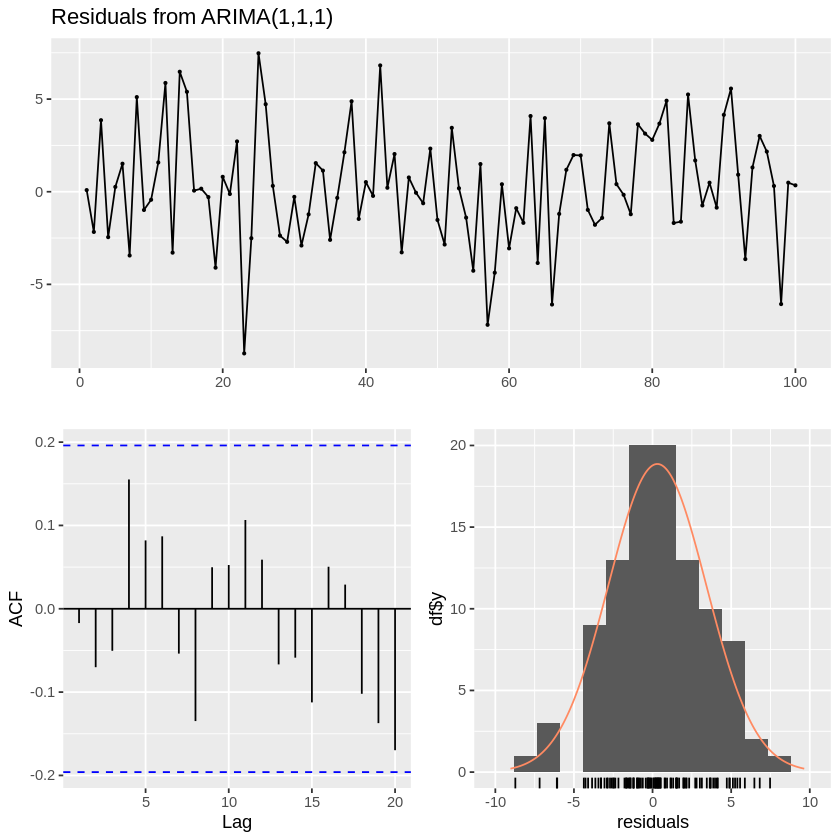

In [70]:
# check Residuals
checkresiduals(arima_111_model)


	Ljung-Box test

data:  Residuals from ARIMA(3,1,0)
Q* = 4.4913, df = 7, p-value = 0.7218

Model df: 3.   Total lags used: 10



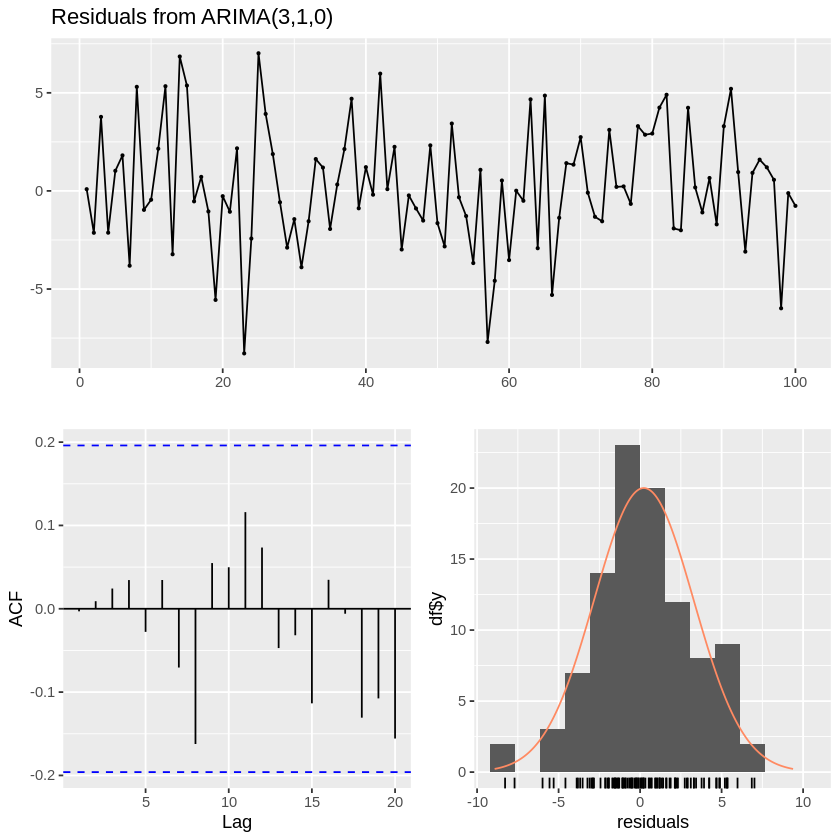

In [71]:
checkresiduals(arima_310_model)


	Ljung-Box test

data:  Residuals from ARIMA(5,1,4)
Q* = 4.6369, df = 3, p-value = 0.2004

Model df: 9.   Total lags used: 12



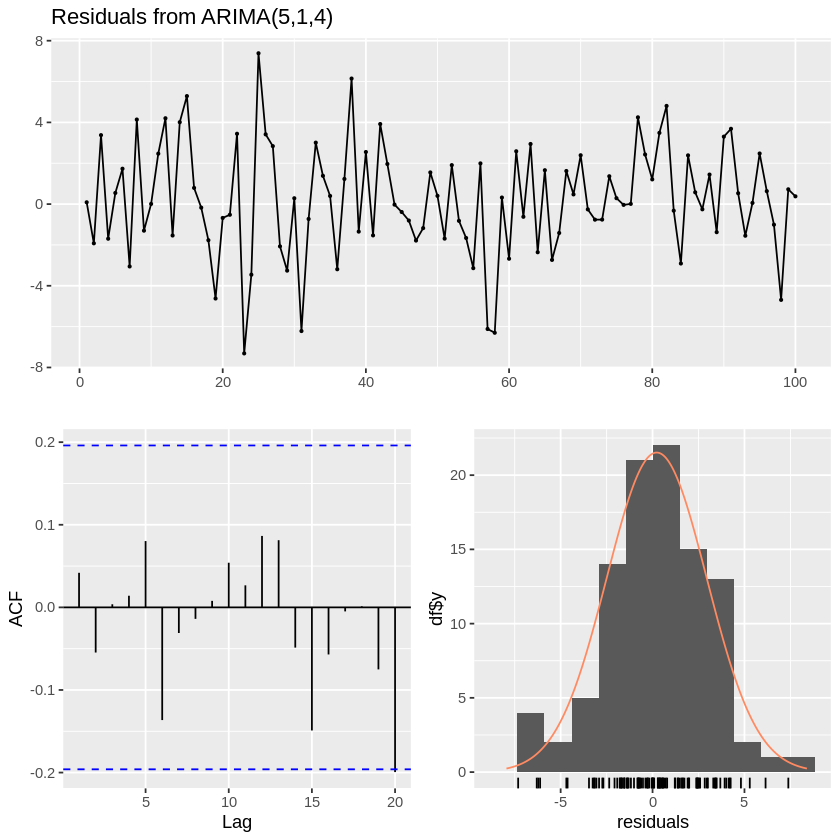

In [72]:
checkresiduals(arima_514_model)


	Ljung-Box test

data:  Residuals from ARIMA(5,2,5)
Q* = 5.6546, df = 3, p-value = 0.1297

Model df: 10.   Total lags used: 13



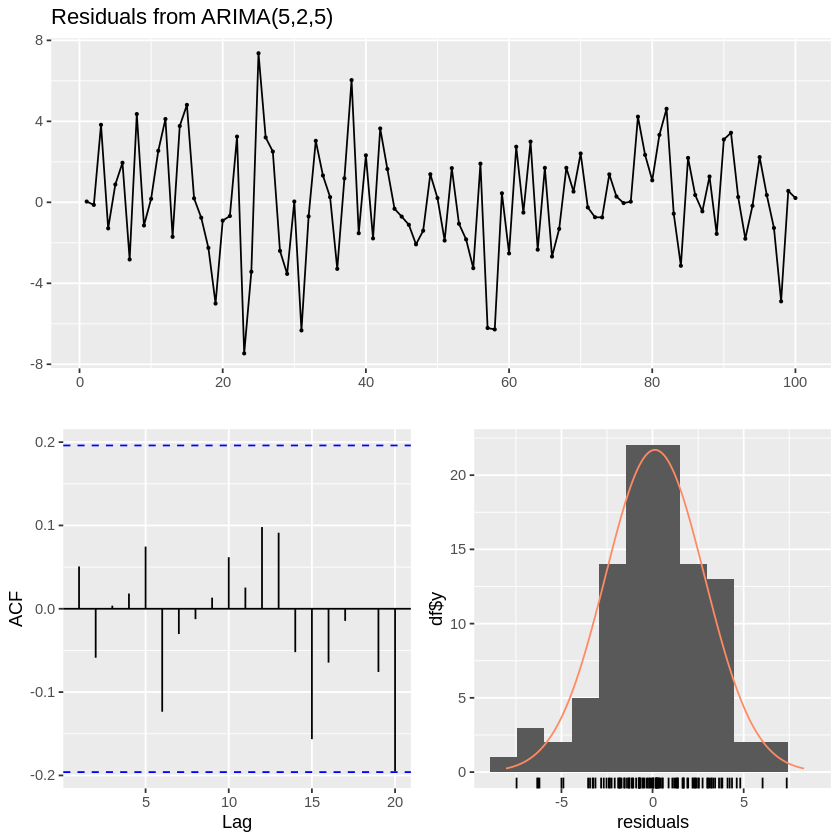

In [73]:

checkresiduals(best_aic_model) #ARIMA(5,2,5)



	Ljung-Box test

data:  Residuals from ARIMA(2,2,0)
Q* = 6.6784, df = 8, p-value = 0.5717

Model df: 2.   Total lags used: 10



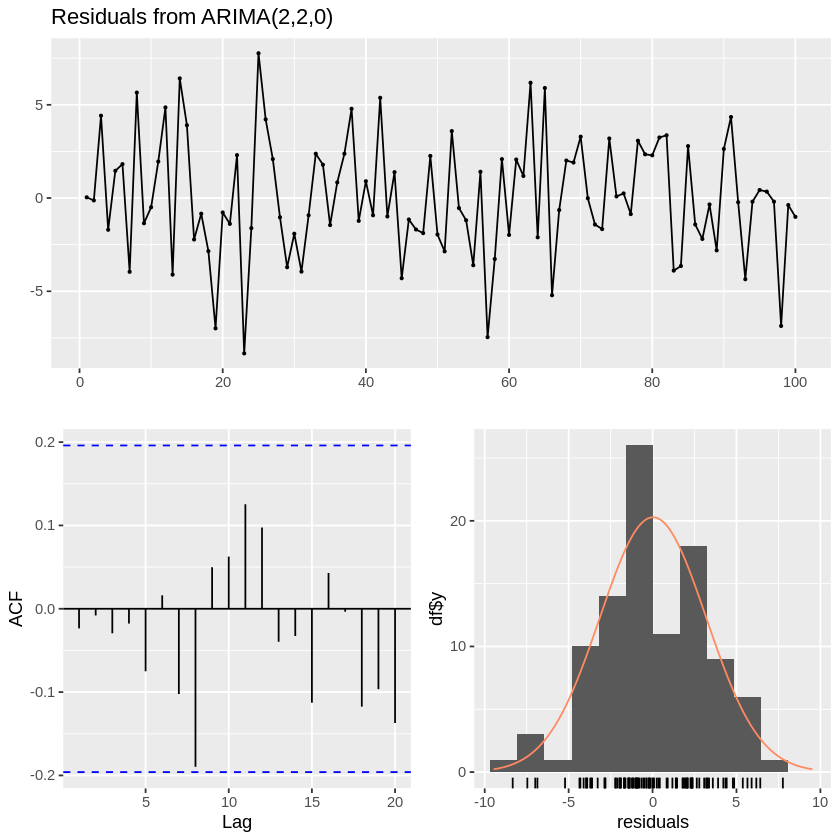

In [74]:
checkresiduals(best_bic_hqc_model) #ARIMA(2,2,0)